In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm

100%|██████████| 5000/5000 [00:14<00:00, 342.70it/s]


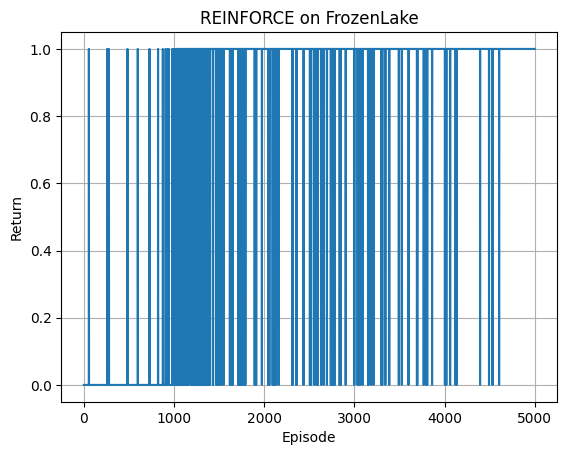

In [2]:
# Environment
SIZE = 8
IS_SLIPPERY = False
env = gym.make('FrozenLake-v1', desc=None, map_name=f"{SIZE}x{SIZE}", is_slippery=IS_SLIPPERY)
state_dim = env.observation_space.n
action_dim = env.action_space.n


# Hyperparameters
lr = 0.001
gamma = 0.99
episodes = 5_000


# Policy network
class Policy(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(state_dim, action_dim)
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )


    def forward(self, x):
        return torch.softmax(self.fc(x), dim=-1)

    def act(self, state):
        probs = self.forward(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        a = action.item()
        log_prob = dist.log_prob(action)
        return a, log_prob


# One-hot encoding
def one_hot(state):
    vec = np.zeros(state_dim, dtype=np.float32)
    vec[state] = 1.0
    return vec


# Init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=lr)

returns_per_episode = []

# Training loop
for _ in tqdm(range(episodes)):
    state, _ = env.reset()
    done = False
    log_probs = []
    rewards = []

    while not done:
        state_tensor = torch.tensor(one_hot(state), device=device)
        action, log_prob = policy.act(state_tensor)
        next_state, reward, terminated, truncated, _ = env.step(action)

        log_probs.append(log_prob)
        rewards.append(reward)

        state = next_state
        done = terminated or truncated

    returns_per_episode.append(sum(rewards))

    # Compute returns
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.append(G)
    returns = torch.tensor(list(reversed(returns)), device=device)

    # Policy update
    loss = -torch.sum(torch.stack(log_probs) * returns)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

env.close()

# Plotting
plt.plot(returns_per_episode)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("REINFORCE on FrozenLake")
plt.grid(True)
plt.show()

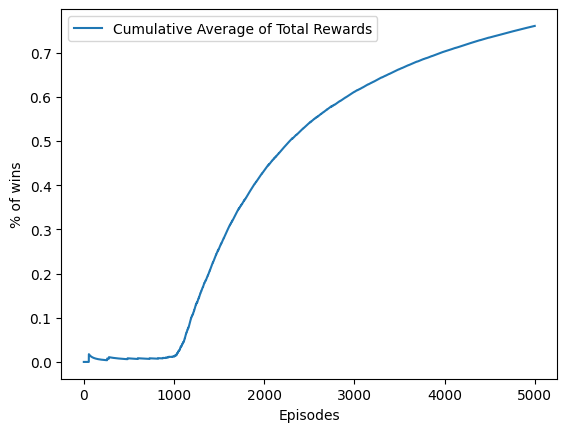

In [3]:
cumulative_avg = np.cumsum(returns_per_episode) / (np.arange(len(returns_per_episode)) + 1)
plt.plot(cumulative_avg, label='Cumulative Average of Total Rewards')
plt.xlabel('Episodes')
plt.ylabel('% of wins')
plt.legend()
plt.show()